In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pybamm
import pandas as pd
import timeit
start = timeit.default_timer()
pybamm.set_logging_level("INFO")

In [2]:
model = pybamm.lithium_ion.DFN(
    options={
        "thermal": "lumped",
        "SEI": "interstitial-diffusion limited",
        "SEI on cracks": "true",
        "SEI film resistance": "distributed", 
        "SEI porosity change": "true",
        "particle mechanics": ("swelling and cracking", "swelling only"),
        "loss of active material": "stress-driven",
        "lithium plating": "partially reversible"
    }
)
param = pybamm.ParameterValues("OKane2023")
# Adjust SEI parameters
param.update({"Inner SEI lithium interstitial diffusivity [m2.s-1]": 3e-19})
# Override SEI thickness dependence of lithium plating
param.update({"Dead lithium decay rate [s-1]": 1e-6})
param.update({"Lithium plating kinetic rate constant [m.s-1]": 1e-10})
# Adjust mechanical degradation parameters
param.update({"Negative electrode cracking rate": 1e-22})
param.update({"Negative electrode LAM constant proportional term [s-1]": 1e-9})
param.update({"Positive electrode LAM constant proportional term [s-1]": 1e-9})

In [3]:
# define experiment
V_max = 4.2;        V_min = 2.5; 
Update_Cycles = 10; RPT_Cycles = 1;
charge_time_mins = 60 * 4.86491/5
exp_AGE_text = [(
    f"Charge at 0.3 C for {charge_time_mins} minutes",
    f"Discharge at 1 C until {V_min} V", 
    ),  ]
# step index for ageing
step_AGE_CD =0;   step_AGE_CC =1;   step_AGE_CV =2;

exp_RPT_text = [ (
    f"Charge at 1C until {V_max} V",  
    f"Hold at {V_max}V until C/100",
    f"Discharge at 0.1C until {V_min} V (5 minute period)",  
    "Rest for 1 hours (5 minute period)",  
    f"Charge at 0.1C until {V_max} V (5 minute period)",
    "Rest for 1 hours (5 minute period)",
    f"Discharge at 1C until {V_min} V",  
    f"Hold at {V_min} V until C/100",
    ) ]
# step index for RPT
step_RPT_CD = 2;  step_RPT_RE =3;   step_RPT_CC = 4;  
Experiment_Long   = pybamm.Experiment( exp_AGE_text * Update_Cycles  )  
Experiment_RPT    = pybamm.Experiment( exp_RPT_text * RPT_Cycles     ) 
Experiment_Breakin= pybamm.Experiment( exp_RPT_text * RPT_Cycles     )


In [4]:
var_pts = {
    "x_n": 5,  # negative electrode
    "x_s": 5,  # separator 
    "x_p": 5,  # positive electrode
    "r_n": 60,  # negative particle
    "r_p": 20,  # positive particle
}

In [5]:
sim1 = pybamm.Simulation(
    model, 
    experiment=Experiment_Breakin,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    var_pts=var_pts,
)
solution1 = sim1.solve(
    save_at_cycles=1
)

stop = timeit.default_timer()
print('running time: ' + str(stop - start) +'s')

running time: 72.6977837s


In [6]:
model_2 = model.set_initial_conditions_from(solution1, inplace=False)
sim2 = pybamm.Simulation(
    model_2, 
    experiment=Experiment_Long,
    parameter_values=param,
    solver=pybamm.CasadiSolver(),
    var_pts=var_pts,
)
solution2 = sim2.solve(
    save_at_cycles=[1,5,10] 
)

In [7]:
# plot SOH, LAM, LII
# SOH must be defined ourselves? 

In [8]:
label = ["Initial solution","Second solution"] 
var = [
    "Loss of lithium inventory, including electrolyte [%]",
    "LAM_ne [%]",
    "Loss of active material in negative electrode [%]",
    "LAM_pe [%]",
    "Loss of active material in positive electrode [%]",
    'LLI [%]', 
    'Throughput capacity [A.h]',
    "Discharge capacity [A.h]"
]
quick_plot = pybamm.QuickPlot(
    [solution1,solution2], var,label,variable_limits='tight') #     
quick_plot.dynamic_plot();

interactive(children=(FloatSlider(value=0.0, description='t', max=23.17562294137274, step=0.2317562294137274),…

In [9]:
print(solution2['Throughput capacity [A.h]'].entries[-1])
print(solution2.cycles[-1].steps[-1]['Throughput capacity [A.h]'].entries[-1])
print(solution2.cycles[-1].steps[1]['Throughput capacity [A.h]'].entries)

37.13174860886047
1.459424375173292
[0.         0.08333333 0.16666667 0.25       0.33333333 0.41666667
 0.5        0.58333333 0.66666667 0.75       0.83333333 0.91666667
 1.         1.08333333 1.16666667 1.25       1.33333333 1.41666667
 1.45942438]


for step in solution2.cycles[-1].steps:
    step['Throughput capacity [A.h]'].entries += solution1['Throughput capacity [A.h]'].entries[-1]

In [10]:
# need to do this every time next solution is got:
solution2['Throughput capacity [A.h]'].entries += solution1['Throughput capacity [A.h]'].entries[-1]
"Throughput energy [W.h]",

('Throughput energy [W.h]',)

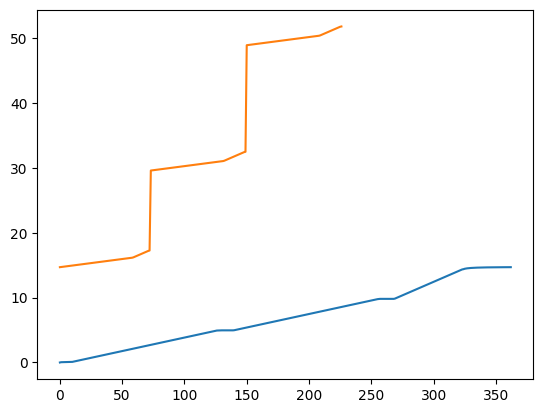

In [13]:
plt.plot(solution1['Throughput capacity [A.h]'].entries)
plt.plot(solution2['Throughput capacity [A.h]'].entries)

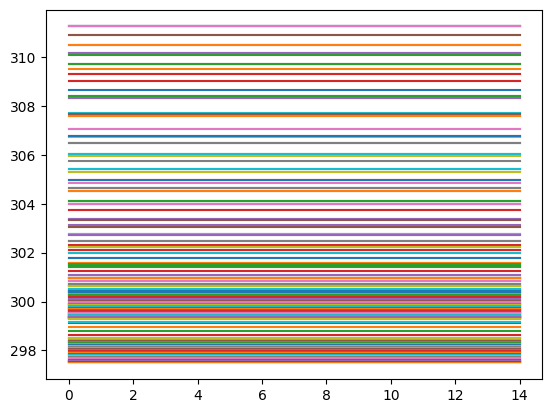

In [11]:
plt.plot(solution2['Cell temperature [K]'].entries )

In [12]:
solution2['Cell temperature [C]'].entries 

array([[27.81351622, 27.67506053, 27.50454386, ..., 37.00377221,
        37.75469088, 38.0990555 ],
       [27.81351622, 27.67506053, 27.50454386, ..., 37.00377221,
        37.75469088, 38.0990555 ],
       [27.81351622, 27.67506053, 27.50454386, ..., 37.00377221,
        37.75469088, 38.0990555 ],
       ...,
       [27.81351622, 27.67506053, 27.50454386, ..., 37.00377221,
        37.75469088, 38.0990555 ],
       [27.81351622, 27.67506053, 27.50454386, ..., 37.00377221,
        37.75469088, 38.0990555 ],
       [27.81351622, 27.67506053, 27.50454386, ..., 37.00377221,
        37.75469088, 38.0990555 ]])